# TEAM 25 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import tqdm
from sklearn.metrics import classification_report, matthews_corrcoef
from networkx.algorithms import connected_components
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Gradient Color Bar Plots
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors as mcolors, path

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

C:\Users\AWWAL\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\AWWAL\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\AWWAL\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\AWWAL\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Helper Functions

In [7]:
def gradientbars(bars,ydata,cmap):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*h/max(ydata),256)).T
        #zorder of 2 to get gradients above the facecolor, but below the bar outlines
        ax.imshow(grad, extent=[x,x+w,y,y+h], origin='lower',aspect="auto",zorder=2, norm=cm.colors.NoNorm(vmin=0,vmax=1),cmap=plt.get_cmap(cmap))
                  
def get_results_list(results, row='high', col='test'):
    tags = []
    scores = []
    for key, val in results.items():
        tags.append(key)
        scores.append(val.loc[row, col])
    return tags, scores

def get_edges(subgraph):
    edges = []
    for node in subgraph:
        try:
            to_nodes = directed_edges[node]
            for to_node in to_nodes:
                edges.append((node, to_node))
        except:pass
    return edges

def get_risk_ratings(subgraph_nodes):
    risk_ratings = []
    for node in subgraph_nodes:
        risk_ratings.append(customerid_risk[node])
        
    return risk_ratings

def get_colors(g_risks):
    color_dict = {'low':'steelblue', 'medium':'khaki', 'high':'tomato'}
    return [color_dict[risk] for risk in g_risks]

def get_weights(edge):
    return df_edges[(df_edges['source'] == edge[0]) & (df_edges['target'] == edge[1])]['emt']

def reinit_subgraph_info():
    global subgraphs_info
    subgraphs_info = pd.DataFrame(data={'subgraphs_risks':[get_risk_ratings(c) for c in subgraphs],
                                     'subgraphs_nodes':[list(sg) for sg in subgraphs],
                                     'subgraphs_len':[len(get_risk_ratings(c)) for c in subgraphs],
                                     'subgraphs_diameter':[nx.diameter(g) for g in subgraphs_graphs],
                                       'subgraphs_edges':[len(g.edges) for g in subgraphs_graphs]})
    
def get_preds(risk_frac):
    risk_dist = {'low':0, 'medium':0, 'high':0}
    try:
        risk_dist['low'] = risk_frac['low']
    except:
        pass
    try:
        risk_dist['medium'] = risk_frac['medium']
    except:
        pass
    try:
        risk_dist['high'] = risk_frac['high']
    except:
        pass
    
    return np.random.choice(['low', 'medium', 'high'], p=list(risk_dist.values()))

def get_risk_props(risk_frac):
    risk_dist = {'low':0, 'medium':0, 'high':0}
    try:
        risk_dist['low'] = risk_frac['low']
    except:
        pass
    try:
        risk_dist['medium'] = risk_frac['medium']
    except:
        pass
    try:
        risk_dist['high'] = risk_frac['high']
    except:
        pass
    
    return risk_dist

class PreprocessData(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 num_cols, 
                 cat_ohe_cols, 
                 cat_non_ohe_cols=None, 
                 imputer=SimpleImputer(strategy='most_frequent'),
                 scaler=StandardScaler(),
                 ohe=OneHotEncoder(handle_unknown='ignore'),
                 ):
   
        self.num_cols = num_cols
        self.cat_ohe_cols = cat_ohe_cols
        self.cat_non_ohe_cols = cat_non_ohe_cols
        self.imputer = imputer
        self.scaler = scaler
        self.ohe = ohe if self.cat_ohe_cols else None
        self.numerical_pipeline = Pipeline(steps=[('scaler', self.scaler)])
        self.categorical_pipeline = Pipeline(steps=[('ohe', self.ohe)])
        if self.ohe:
            self.preprocessor = ColumnTransformer(transformers=[('num', self.numerical_pipeline, num_cols),
                                                   ('cat', self.categorical_pipeline, cat_ohe_cols)],
                                     remainder='passthrough')
        else:
            self.preprocessor = ColumnTransformer(transformers=[('num', self.numerical_pipeline, num_cols)],
                                 remainder='passthrough')
        
    def fit(self, X, y=None):
        self.preprocessor.fit(X)
        if self.ohe:
            self.cat_cols_name = list(self.preprocessor.transformers_[1][1]['ohe'].get_feature_names(self.cat_ohe_cols))
        else:
            self.cat_cols_name = []
        return self
    
    def transform(self, X, y=None):
        
        X = pd.DataFrame(self.preprocessor.transform(X), columns=self.num_cols+self.cat_cols_name+self.cat_non_ohe_cols)
        return X
        
#     def ocptn_fe(self, X, y, test=False):
#         if not test:
#             pd.concat([X['OCPTN_NM'], y.reset_index(drop=True)], axis=1).groupby()
 
#         return X

def get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols,
             n_folds=10,
             model_type='Catboost'):

    temp = data.copy()


    temp.drop(['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA'], axis=1, inplace=True)
    try:
        temp['OCPTN_NM'] = temp['OCPTN_NM'].fillna(temp['OCPTN_NM'].mode()[0]).astype(int)
    except:
        pass

    X = temp.drop('RISK', axis=1)
    y = temp['RISK']


    target_mapping = {'low':0, 'medium':1, 'high':2}
    y = y.map(target_mapping)

    skf = StratifiedKFold(n_splits=n_folds, random_state=None, shuffle=False)
    
    fold_dict = dict()
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)


        preprocessor = PreprocessData(num_cols=num_cols, 
                                   cat_ohe_cols=cat_ohe_cols, 
                                   cat_non_ohe_cols=cat_non_ohe_cols)
     
        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
        X_test = preprocessor.transform(X_test)
        
        if model_type == 'Catboost':
            for col in cat_non_ohe_cols:
                try:
                    X_train[col] = X_train[col].astype(int)
                    X_val[col] = X_val[col].astype(int)
                    X_test[col] = X_test[col].astype(int)
                except:
                    pass
        
#         else:
#             X_train.drop(['OCPTN_NM'], axis=1, inplace=True)
#             X_val.drop(['OCPTN_NM'], axis=1, inplace=True)
#             X_test.drop(['OCPTN_NM'], axis=1, inplace=True)
        
        fold_dict[f'fold_{i+1}'] = X_train, X_val, X_test, y_train, y_val, y_test
         
    return fold_dict

def run_model(model, fold_dict, kwargs=None, remove_sg_2=False):
    f1_scores_train=[]
    f1_scores_val=[]
    f1_scores_test=[]
    mcc = []
    for fold, dataset in tqdm.tqdm(fold_dict.items()):
        X_train, X_val, X_test, y_train, y_val, y_test = dataset
        if kwargs is not None:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
        else:
            model.fit(X_train, y_train)
            
        if remove_sg_2:
            try:
                train_cond = ~(X_train['subgraph_size'] == 2)
                val_cond = ~(X_val['subgraph_size'] == 2)
                test_cond = ~(X_test['subgraph_size'] == 2)
                X_train, y_train = X_train[train_cond], y_train[train_cond]
                X_val, y_val = X_val[val_cond], y_val[val_cond]
                X_test, y_test = X_test[test_cond], y_test[test_cond]
            except:
                train_cond = (nodes_aug.loc[y_train.index]['subgraph_size'] == 2)
                val_cond = (nodes_aug.loc[y_val.index]['subgraph_size'] == 2)
                test_cond = (nodes_aug.loc[y_test.index]['subgraph_size'] == 2)
                X_train, y_train = X_train[train_cond.values], y_train[train_cond.values]
                X_val, y_val = X_val[val_cond.values], y_val[val_cond.values]
                X_test, y_test = X_test[test_cond.values], y_test[test_cond.values]
            
        
        y_train_preds = model.predict(X_train)
        y_val_preds = model.predict(X_val)
        y_test_preds = model.predict(X_test)
        f1_scores_train.append(f1_score(y_train, y_train_preds, average=None))
        f1_scores_val.append(f1_score(y_val, y_val_preds, average=None))
        f1_scores_test.append(f1_score(y_test, y_test_preds, average=None))
        mcc.append([matthews_corrcoef(y_train, y_train_preds), 
                    matthews_corrcoef(y_val, y_val_preds), 
                    matthews_corrcoef(y_test, y_test_preds)])
        
    train_f1 = np.array(f1_scores_train).mean(axis=0)
    val_f1 = np.array(f1_scores_val).mean(axis=0)
    test_f1 = np.array(f1_scores_test).mean(axis=0)
    mcc = np.array(mcc).mean(axis=0)
    results = pd.DataFrame(np.vstack([np.array([train_f1, val_f1, test_f1]).T, mcc]), 
                 columns=['train', 'val', 'test'], 
                 index=['low', 'medium', 'high', 'mcc'])
    return results

### FEATURE ENGINEERING IDEAS

* Distance from other high risk people/ distance from people with low risk but having connection with high risk people
* proximity(based on distance and money transfered) score for every node with respect to high/medium risk people? this can help us calculate the danger level of the money sending. 

* **Cluster out graphs into smaller graphs, does the most central nodes are the high risk nodes**?

### EDA/fe ideas

* Average distance of different risk classes form each other on the graph.
* Average money transfer amount using box plots
* Money transfer amount/ transfer counts to different classes. we want to see how much average money does a class transfer to other class using boxplots and how much in comparison to 

* Avg distance that a node has with itself through all the possible routes.
* Frac of outgonig and incoming links forming a loop back.


## Things to focus on

* not any fancy graph theory concept, rather look at money laundering ways and distill the central idea of the money laundering technique into graph theory based information


* **perform eda for difference in clustering for high risk people belonging to high degree and bigger graph sizes, before and after FE**

* **Perform shap to visualize the value of feature engineered features**
* at this point try doing greedy feature selection
* plot dataset size vs score metric to show if 1 mil and .36 mil difference made any significant difference or not.

In [8]:
df_edges = pd.read_csv('UofT_edges.csv')
df_nodes = pd.read_csv('UofT_nodes.csv')
df_edges = df_edges.merge(df_nodes[['CUSTOMER_ID', 'RISK']], how='left', left_on='target', right_on='CUSTOMER_ID').drop('CUSTOMER_ID', axis=1)

In [9]:
V = set(df_edges['source'].to_list() + df_edges['target'].to_list())
E = [tuple(arr) for arr in list(df_edges.to_numpy())]
E = [(arr[0], arr[1], (arr[2], arr[3])) for arr in E]

In [10]:
DiG = nx.DiGraph()
DiG.add_nodes_from(V)
DiG.add_weighted_edges_from(E)

In [11]:
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

In [12]:
nodes_df = pd.DataFrame(data={'CUSTOMER_ID':list(G.nodes)})

### EDGE RISK SOURCE RISK RELATION

In [13]:
customerid_risk = df_nodes[['CUSTOMER_ID', 'RISK']].set_index('CUSTOMER_ID')['RISK']

In [14]:
df_edges['source_risk'] = df_edges['source'].map(customerid_risk)
df_edges['target_risk'] = df_edges['target'].map(customerid_risk)

# 1. Feature Engineering and EDA

### 1.1 Degree vs risk

In [15]:
degree = nx.degree(G)
temp = pd.Series(dict(degree)).reset_index().rename({'index':'CUSTOMER_ID', 0:'degree'}, axis=1)
temp['RISK'] = temp['CUSTOMER_ID'].map(customerid_risk)

temp2 = temp.groupby('degree').apply(lambda df:df['RISK'].value_counts()/len(df)).reset_index()
temp2 = temp2[temp2['degree'] <= 13]
high_line = temp2[temp2['level_1'] == 'high'].sort_values(by='degree')['RISK']
medium_line = temp2[temp2['level_1'] == 'medium'].sort_values(by='degree')['RISK']
low_line = temp2[temp2['level_1'] == 'low'].sort_values(by='degree')['RISK']

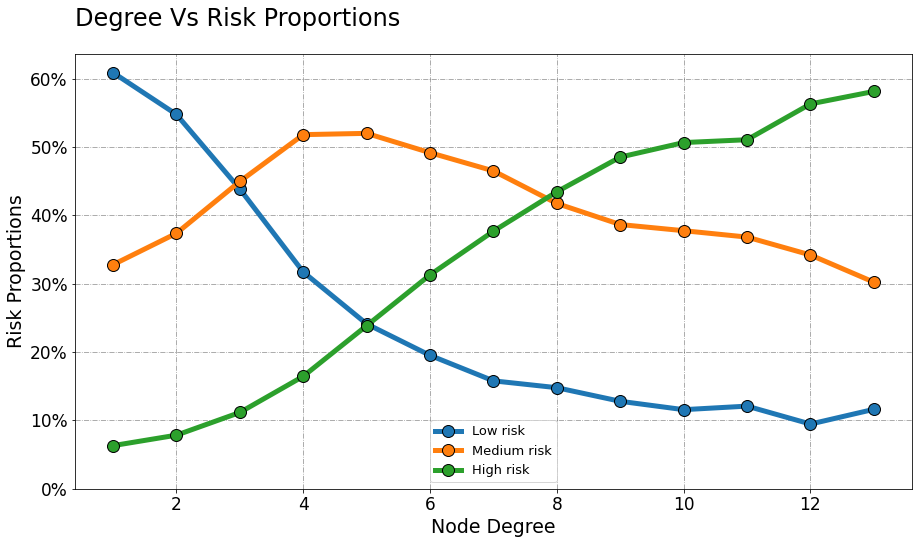

In [16]:
plt.figure(figsize=(15, 8))

plt.plot(range(1, 14), low_line, '-o', linewidth=5, markersize=12, mec='k', label='Low risk')
plt.plot(range(1, 14), medium_line, '-o', linewidth=5, markersize=12, mec='k', label='Medium risk')
plt.plot(range(1, 14), high_line, '-o', linewidth=5, markersize=12, mec='k', label='High risk')

plt.title('Degree Vs Risk Proportions', fontsize=24, loc='Left', y=1.05)

plt.ylabel('Risk Proportions', fontsize=19)
plt.yticks(ticks=[0.1*i for i in range(7)], labels=[f'{i*10}%' for i in range(7)], fontsize=17)

plt.xlabel('Node Degree', fontsize=19)
plt.xticks(fontsize=17)


plt.legend(fontsize=13)
plt.grid(alpha=0.4, linestyle='-.', color='k')
plt.show()

In [17]:
nodes_df['degree'] = nodes_df['CUSTOMER_ID'].map(dict(nx.degree(G)))

### 1.2 Risk level effect on closeness centrality

Assumption : Given the fact that to effectively do money laundering money has to be done in small batches and money has to be sent to multiple links, those links further might need to send money to multiple links. Finally money finds its way again back to the source.

#### Directional graph

In [18]:
cc = nx.closeness_centrality(DiG)
temp = pd.Series(cc).reset_index().rename({'index':'CUSTOMER_ID', 0:'closeness_centrality'}, axis=1)
temp['RISK'] = temp['CUSTOMER_ID'].map(customerid_risk)

In [19]:
temp['cc_bin'] = pd.qcut(temp['closeness_centrality'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                         labels=range(6)
                             , duplicates='drop')

temp2 = temp.groupby('cc_bin').apply(lambda df:df['RISK'].value_counts()/len(df)).reset_index()
high_line = temp2[temp2['level_1'] == 'high'].sort_values(by='cc_bin')['RISK']
medium_line = temp2[temp2['level_1'] == 'medium'].sort_values(by='cc_bin')['RISK']
low_line = temp2[temp2['level_1'] == 'low'].sort_values(by='cc_bin')['RISK']

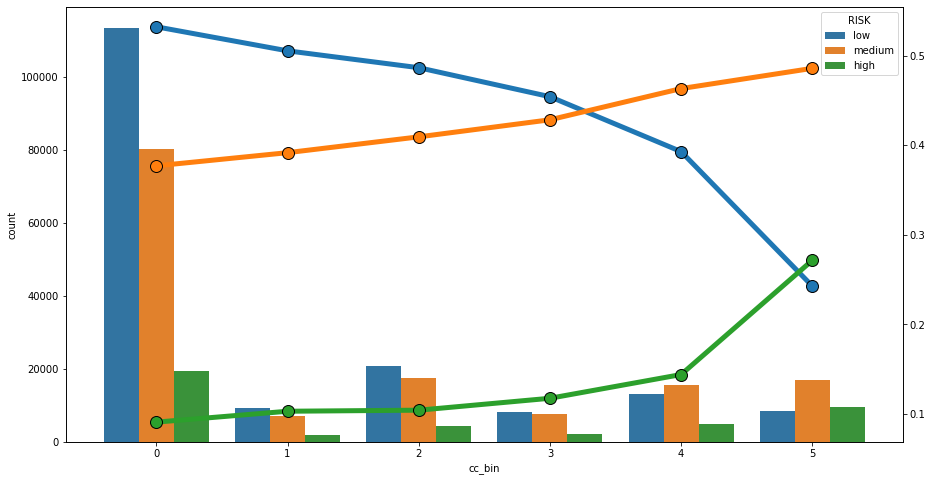

In [20]:
plt.figure(figsize=(15, 8))
sns.countplot(x='cc_bin', hue='RISK', data=temp)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(range(6), low_line, '-o', linewidth=5, markersize=12, mec='k')
ax2.plot(range(6), medium_line, '-o', linewidth=5, markersize=12, mec='k')
ax2.plot(range(6), high_line, '-o', linewidth=5, markersize=12, mec='k')
plt.show()

**Inferences**:
* there seem to be many "high" risk nodes with closeness centrality very low in the case of the directional graph. This seems to be because they might not have many directed out edges, low centrality.

#### Non directional graph

In [21]:
cc = nx.closeness_centrality(G)
temp = pd.Series(cc).reset_index().rename({'index':'CUSTOMER_ID', 0:'closeness_centrality'}, axis=1)
temp['RISK'] = temp['CUSTOMER_ID'].map(customerid_risk)

In [22]:
temp['cc_bin'] = pd.qcut(temp['closeness_centrality'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                         labels=[i for i in range(9)]
                             , duplicates='drop')

temp2 = temp.groupby('cc_bin').apply(lambda df:df['RISK'].value_counts()/len(df)).reset_index()
high_line = temp2[temp2['level_1'] == 'high'].sort_values(by='cc_bin')['RISK']
medium_line = temp2[temp2['level_1'] == 'medium'].sort_values(by='cc_bin')['RISK']
low_line = temp2[temp2['level_1'] == 'low'].sort_values(by='cc_bin')['RISK']

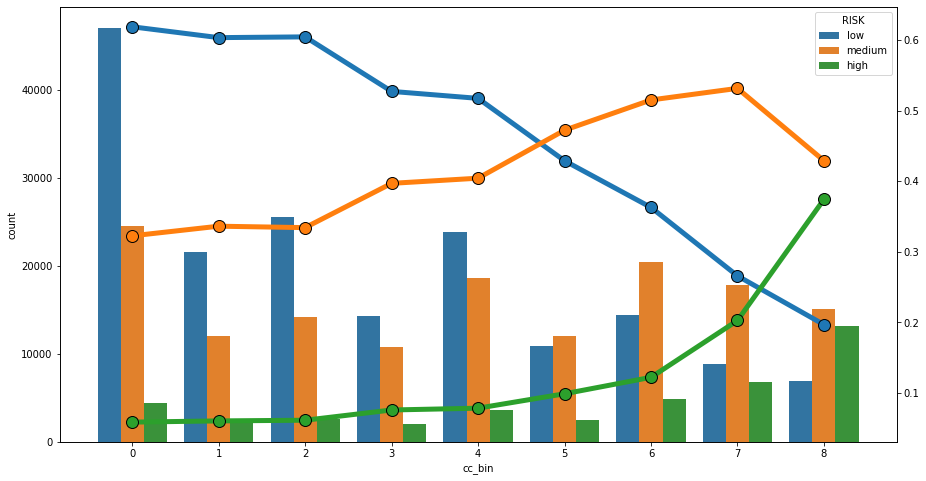

In [23]:
#temp2 = temp[['source', 'closeness_centrality', 'cc_bin', 'RISK']].drop_duplicates()
plt.figure(figsize=(15, 8))
sns.countplot(x='cc_bin', hue='RISK', data=temp)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot([i for i in range(9)], low_line, '-o', linewidth=5, markersize=12, mec='k')
ax2.plot([i for i in range(9)], medium_line, '-o', linewidth=5, markersize=12, mec='k')
ax2.plot([i for i in range(9)], high_line, '-o', linewidth=5, markersize=12, mec='k')
plt.show()

**Inferences**:
* In Undirectional graph we have a better trend in "high" risk nodes proportion increase as centrality increases

In [24]:
nodes_df['closeness_centrality'] = nodes_df['CUSTOMER_ID'].map(dict(nx.closeness_centrality(G)))

### 1.3 Different graph components

In [25]:
# Undirected graphs
subgraphs = [sub_g for sub_g in connected_components(G)]
subgraphs_graphs = [G.subgraph(c) for c in connected_components(G)]
subgraphs_list = [nx.Graph() for i in range(len(subgraphs_graphs))]
[g.add_edges_from(list(c.edges)) for g, c in zip(subgraphs_list, subgraphs_graphs)]


# Directed graphs

directed_edges = df_edges.groupby('source').apply(lambda df: df['target'].to_list())

disubgraphs_list = []
for g in tqdm.tqdm(subgraphs):
    E  = get_edges(g)
    V = g
    dig = nx.DiGraph()
    dig.add_nodes_from(V)
    dig.add_edges_from(E)
    disubgraphs_list.append(dig)

100%|█████████████████████████████████████████████████████████████████████████| 81528/81528 [00:04<00:00, 18598.10it/s]


In [26]:
len(subgraphs)

81528

In [27]:
len(set(list(np.hstack([list(g) for g in subgraphs]))))

361178

In [28]:
len(cc)

361178

In [29]:
subgraphs_info = pd.DataFrame(data={'subgraphs_risks':[get_risk_ratings(c) for c in subgraphs],
                                     'subgraphs_nodes':[list(sg) for sg in subgraphs],
                                     'subgraphs_len':[len(get_risk_ratings(c)) for c in subgraphs],
                                     #'subgraphs_diameter':[nx.diameter(g) for g in subgraphs_graphs],
                                       'subgraphs_edges':[len(g.edges) for g in subgraphs_graphs],
                                    'subgraphs_density':[nx.density(g) for g in subgraphs_list]})

In [30]:
lens = subgraphs_info['subgraphs_len']
lens = lens.where(lens<11, 10).value_counts().sort_values()

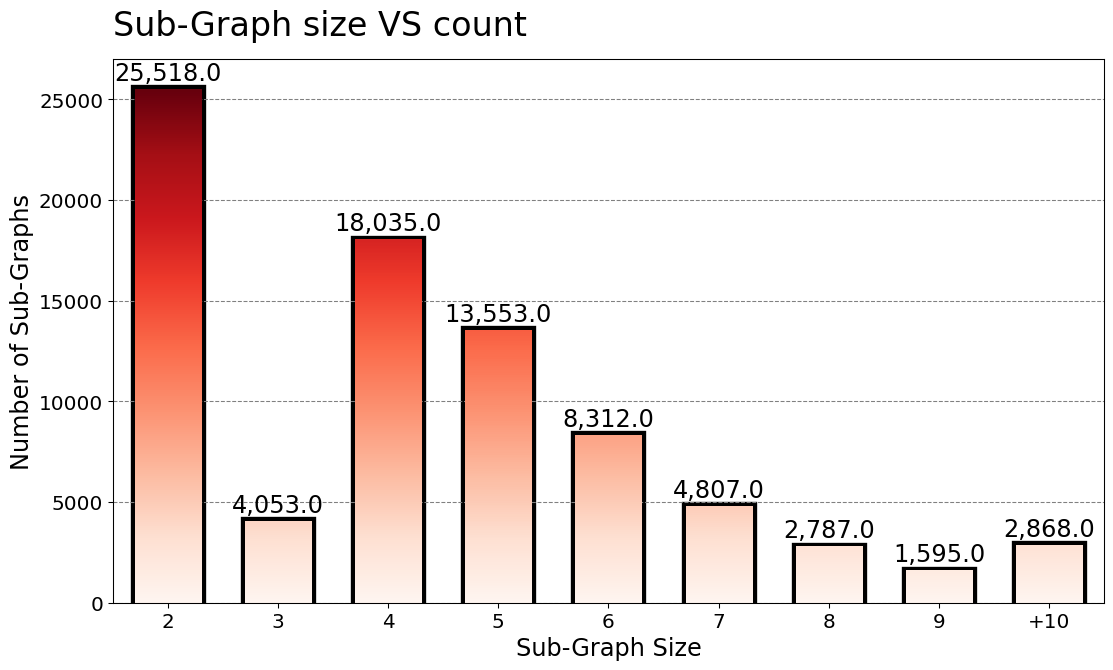

In [31]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
ax = plt.gca()
bar1 = ax.bar(x = lens.index, height = lens, width=0.6, edgecolor='k', linewidth=7)
ax.bar_label(bar1, labels=[f'{e:,.1f}' for e in lens], padding=3, color='black', fontsize=18)
gradientbars(bar1, lens.values, 'Reds')


plt.ylabel('Number of Sub-Graphs', fontsize=18)
plt.yticks(fontsize=15)
plt.title('Sub-Graph size VS count', fontsize=25, loc='left', y=1.03)

plt.xlabel('Sub-Graph Size', fontsize=18)
plt.xticks(range(2, 11), labels=[i if i !=10 else '+10'for i in range(2, 11)])
plt.xticks(fontsize=15)
plt.axis([1.5, 10.5, 0, 27000])
ax.grid(which='major', axis='y', linestyle='--', color='gray', zorder=0)
plt.show()

**Inference** : the above proves that the whole graph object G is made up of 81528 different smaller graphs which are not connected with each other. the analysis around graph loop and distance should be done per small graph basis.

#### Number of nodes in subgraphs

In [32]:
# perform eda for 2 to 4 size graphs and see if there is a pattern between 

subgraphs_info['subgraphs_len'].value_counts()

2       25518
4       18035
5       13553
6        8312
7        4807
3        4053
8        2787
9        1595
10        994
11        659
12        390
13        313
14        192
15        124
16         59
17         57
18         36
20         14
19         13
21          6
23          4
999         1
22          1
24          1
25          1
155         1
351         1
2538        1
Name: subgraphs_len, dtype: int64

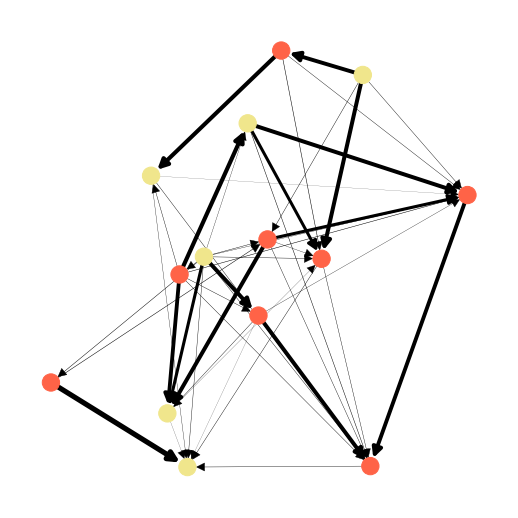

In [30]:
# money shift in bulk - 15

n = 10
plt.figure(figsize=(7, 7))
weights = [get_weights(edge)/1000 for edge in list(disubgraphs_list[n].edges)]
nx.draw(disubgraphs_list[n], node_color=get_colors(subgraphs_info['subgraphs_risks'].iloc[n]), width=weights, arrowsize=20)

### Node is part of which subgraph? 

**Assumption:** We have around 80000 subgraphs for around 300000 nodes. if a small subgraph holding many high and medium risk people can also be called to be a high/medium risk graph, hence a new entry into that graph can also be given higher risk rating.

#### Relation between graphs size and presence of risk labels

In [33]:
unique_sizes = np.sort(subgraphs_info['subgraphs_len'].unique())

risk_proportions = []

for s in unique_sizes:
    if s <= 14:
        
        temp = pd.Series(subgraphs_info[subgraphs_info['subgraphs_risks'].apply(lambda x:len(x) == s)]['subgraphs_risks'].sum())
        risk_proportions.append((s, temp.value_counts()/len(temp)))
        
    else:
        
        temp = pd.Series(subgraphs_info[subgraphs_info['subgraphs_risks'].apply(lambda x:(len(x) >= s) & (len(x) < 26))]['subgraphs_risks'].sum())
        risk_proportions.append((s, temp.value_counts()/len(temp)))
        break
        


low_props = [tup[1]['low'] for tup in risk_proportions]
medium_props = [tup[1]['medium'] for tup in risk_proportions]
high_props = [tup[1]['high'] for tup in risk_proportions]        

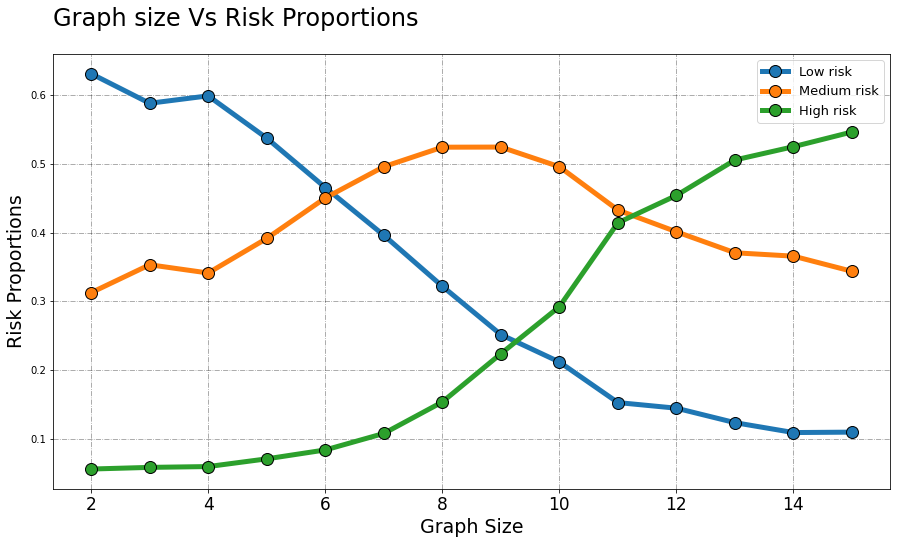

In [34]:
plt.figure(figsize=(15, 8))

plt.plot(range(2, 16), low_props, '-o', linewidth=5, markersize=12, mec='k', label='Low risk')
plt.plot(range(2, 16), medium_props, '-o', linewidth=5, markersize=12, mec='k', label='Medium risk')
plt.plot(range(2, 16), high_props, '-o', linewidth=5, markersize=12, mec='k', label='High risk')

plt.title('Graph size Vs Risk Proportions', fontsize=24, loc='Left', y=1.05)

plt.ylabel('Risk Proportions', fontsize=19)
#plt.yticks(ticks=[0.1*i for i in range(7)], labels=[f'{i*10}%' for i in range(7)], fontsize=17)

plt.xlabel('Graph Size', fontsize=19)
plt.xticks(fontsize=17)


plt.legend(fontsize=13)
plt.grid(alpha=0.4, linestyle='-.', color='k')
plt.show()

In [35]:
len_node_dict = dict()
for s in unique_sizes:
     if s <= 14:
        
        temp = subgraphs_info[subgraphs_info['subgraphs_len'] == s]['subgraphs_nodes'].sum()
        for i in temp:
            len_node_dict[i] = s
      
     else:
        temp = subgraphs_info[subgraphs_info['subgraphs_len'] >= s]['subgraphs_nodes'].sum()
        for i in temp:
            len_node_dict[i] = s
        break

In [36]:
nodes_df['subgraph_size'] = nodes_df['CUSTOMER_ID'].map(len_node_dict)

#### Does Subgraphs proportions dictate new node risk levels?

**Assumptions**: as the subgraphs are very small and may hold network of many related customers, if proportion of high/medium risk individual is more in the subgraph, the new included individual can also be a high/medium risk individual...

In [32]:
y_true = []
y_pred = []

for i in tqdm.tqdm(range(100000)):
    # get the graph index
    subgraphs_ind = np.random.randint(0, len(subgraphs))
    # get the graph
    sg = subgraphs_info['subgraphs_risks'][subgraphs_ind].copy()
    # get the index for the node to remove
    sg_ind_remove = np.random.randint(0, len(sg))
    # remove the node and store the risk label
    y_true.append(sg.pop(sg_ind_remove))
    
    y_pred.append(get_preds((pd.Series(sg).value_counts()/len(sg)).to_dict()))
    
    

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:00<00:00, 1644.89it/s]


In [39]:
reinit_subgraph_info()

In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        high       0.21      0.20      0.21      8694
         low       0.64      0.64      0.64     53759
      medium       0.48      0.48      0.48     37547

    accuracy                           0.54    100000
   macro avg       0.44      0.44      0.44    100000
weighted avg       0.54      0.54      0.54    100000



In [35]:
matthews_corrcoef(y_true, y_pred)

0.18715269445911661

In [36]:
risk_prop = customerid_risk.value_counts()/len(customerid_risk)

y_true2 = []
y_pred2 = []

for i in tqdm.tqdm(range(100000)):
    y_true2.append(customerid_risk.iloc[np.random.randint(0, len(customerid_risk))])
    y_pred2.append(get_preds(risk_prop))

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 21990.20it/s]


In [37]:
print(classification_report(y_true2, y_pred2))

              precision    recall  f1-score   support

        high       0.05      0.05      0.05      5013
         low       0.60      0.60      0.60     60067
      medium       0.35      0.35      0.35     34920

    accuracy                           0.49    100000
   macro avg       0.34      0.34      0.34    100000
weighted avg       0.49      0.49      0.49    100000



In [38]:
matthews_corrcoef(y_true2, y_pred2)

0.006102340580805802

In [406]:
# Risk subgraph proportions intialization
temp = subgraphs_info.copy()
temp['subgraphs_nodes_explode'] = subgraphs_info['subgraphs_nodes']
temp = temp.explode('subgraphs_nodes_explode')

Results for this are very bad!! training score is very good but validation and test results detoriate.

## Node Degree Vs subgraphs avg degree frac

How higher is the degree of the node compared to the average degree of the subgroup nodes/**or what is the frac of node degree and graph order** for different risk labels across different subgroups sizes.

It can be the case that high risk nodes in large subgroups might have on average very high degree as compared to the average degree of the subgroup.

In [37]:
customer_risk = df_nodes[['CUSTOMER_ID', 'RISK']].set_index('CUSTOMER_ID')['RISK']
temp = subgraphs_info.copy()
temp['subgraphs_nodes_explode'] = temp['subgraphs_nodes']
temp = temp.explode('subgraphs_nodes_explode')
temp['subgraphs_avg_degree'] = temp.apply(lambda x:np.mean([degree[node] for node in x['subgraphs_nodes'] if node != x['subgraphs_nodes_explode']]), axis=1)
temp['degree'] = temp['subgraphs_nodes_explode'].apply(lambda x: degree[x])
temp['node_sg_degree_frac'] = temp['degree'] / temp['subgraphs_avg_degree']
temp['RISK'] = temp['subgraphs_nodes_explode'].map(customer_risk)

In [38]:
mapper = temp[['subgraphs_nodes_explode', 'node_sg_degree_frac']].set_index('subgraphs_nodes_explode')['node_sg_degree_frac']
nodes_df['node_sg_degree_frac'] = nodes_df['CUSTOMER_ID'].map(mapper)

## Cycle information for graphs
https://networkx.org/documentation/stable/reference/algorithms/cycles.html
 
 

## Average money coming in and out frac


In [39]:
money_sent = df_edges.groupby('source')['emt'].sum().reset_index()
missing_ids = set(nodes_df['CUSTOMER_ID']) - set(money_sent['source'])
missing_ids = pd.Series([0 for i in range(len(missing_ids))], index=missing_ids, name='emt').reset_index().rename({'index':'source'}, axis=1)
money_sent = pd.concat([money_sent, missing_ids], axis=0).rename({'source':'CUSTOMER_ID', 'emt':'sent'}, axis=1).sort_values('CUSTOMER_ID')

money_received = df_edges.groupby('target')['emt'].sum().reset_index()
missing_ids = set(nodes_df['CUSTOMER_ID']) - set(money_received['target'])
missing_ids = pd.Series([0 for i in range(len(missing_ids))], index=missing_ids, name='emt').reset_index().rename({'index':'target'}, axis=1)
money_received = pd.concat([money_received, missing_ids], axis=0).rename({'target':'CUSTOMER_ID', 'emt':'received'}, axis=1).sort_values('CUSTOMER_ID')

money_transfer = money_sent.merge(money_received, how='outer', on='CUSTOMER_ID')
temp = nodes_df.merge(money_transfer, on='CUSTOMER_ID', how='inner')
temp['RISK'] = temp['CUSTOMER_ID'].map(df_nodes[['CUSTOMER_ID', 'RISK']].set_index('CUSTOMER_ID')['RISK'])
#money_transfer['sent'].where(money_transfer['sent'] != 0, 1, inplace=True)
#money_transfer['received'].where(money_transfer['received'] != 0, 1, inplace=True)

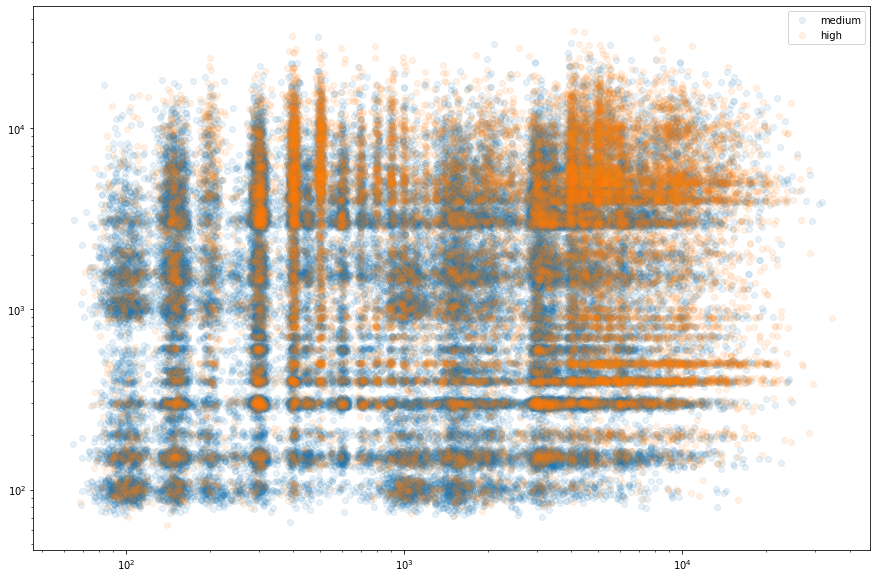

In [40]:
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
#ax.plot(temp['sent'][temp['RISK'] == 'low'], temp['received'][temp['RISK'] == 'low'], 'o', alpha=0.1, label='low')
ax.plot(temp['sent'][temp['RISK'] == 'medium'], temp['received'][temp['RISK'] == 'medium'], 'o', alpha=0.1, label='medium')
ax.plot(temp['sent'][temp['RISK'] == 'high'], temp['received'][temp['RISK'] == 'high'], 'o', alpha=0.1, label='high')#, markeredgecolor='none')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

In [41]:
nodes_df = nodes_df.merge(money_transfer, on='CUSTOMER_ID', how='inner')

In [42]:
nodes_df

,CUSTOMER_ID,degree,closeness_centrality,subgraph_size,node_sg_degree_frac,sent,received
0,5.0,1,0.000004,4,0.600000,0.000000,2885.539505
1,7.0,4,0.000015,10,0.900000,8479.076150,3880.751984
2,11.0,3,0.000009,5,1.333333,2910.499409,4169.124004
3,16.0,4,0.000012,7,1.200000,0.000000,495.207727
4,25.0,1,0.000004,4,0.600000,311.526741,0.000000
...,...,...,...,...,...,...,...
361173,1000667.0,4,0.000012,6,2.000000,2267.757801,1624.598860
361174,1000671.0,2,0.000006,5,1.000000,2330.239815,0.000000
361175,1000672.0,1,0.000006,5,0.307692,114.625882,0.000000
361176,1000673.0,1,0.000003,2,1.000000,161.419638,0.000000


## Money displacement vs number of edges

From experience looking at graphs, the graphs with higher proportions of 'high', 'medium' risks are those in which a lot of money is being displaced. make a feature which calculates money displaced vs node present. eg difference between graph 3 and 10

In [43]:
money_displaced = []
for i in tqdm.tqdm(range(len(subgraphs_list))):
    money_displaced.append(sum([get_weights(edge).iloc[0] for edge in list(disubgraphs_list[i].edges)]))

100%|███████████████████████████████████████████████████████████████████████████| 81528/81528 [07:44<00:00, 175.41it/s]


In [44]:
temp = subgraphs_info.copy()
temp['money_displaced_nedge_frac'] = np.array(money_displaced) / temp['subgraphs_edges']
temp = temp.explode('subgraphs_nodes')

In [45]:
mapper = temp[['subgraphs_nodes', 'money_displaced_nedge_frac']].set_index('subgraphs_nodes')['money_displaced_nedge_frac']
nodes_df['money_displaced_nedge_frac'] = nodes_df['CUSTOMER_ID'].map(mapper)

In [46]:
temp = subgraphs_info.copy()
temp['money_displaced_nedge_frac'] = np.array(money_displaced) / temp['subgraphs_edges']

In [47]:
temp[['low_frac', 'medium_frac', 'high_frac']] = temp['subgraphs_risks'].apply(lambda x:pd.Series(get_risk_props(pd.Series(x).value_counts()/len(x))))

<Axes: >

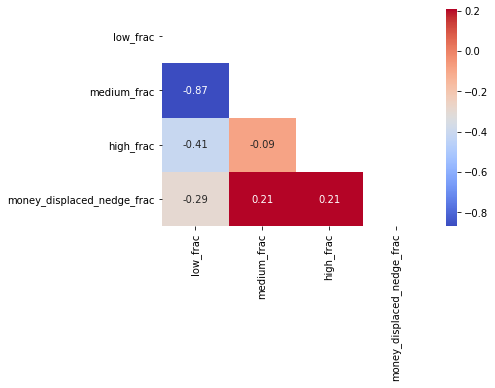

In [48]:
corr=temp[['low_frac', 'medium_frac', 'high_frac', 'money_displaced_nedge_frac']].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix, cmap='coolwarm')

#sns.heatmap(temp[['low_frac', 'medium_frac', 'high_frac', 'money_displaced_nedge_frac']].corr(), cmap='coolwarm')

## Closely study small subgraphs 

53015


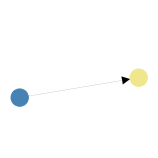

In [253]:
# money shift in bulk - 15
ind = np.random.choice(subgraphs_info[subgraphs_info['subgraphs_len'] == 2].index)
print(ind)

n = ind
plt.figure(figsize=(2, 2))
weights = [get_weights(edge)/1000 for edge in list(disubgraphs_list[n].edges)]
nx.draw(disubgraphs_list[n], node_color=get_colors(subgraphs_info['subgraphs_risks'].iloc[n]), width=weights, arrowsize=20)

**Inference**: nothing can be understood from 2 node subgraphs, there are very few variables in this setup which can be used to generate newer information or feature engineering ideas with just 2 nodes and 1 edge 

## Edges vs nodes feature

**Assumption**: if we have more edges as compared to nodes, that can be indication of strongly connected graph and a lot of complex money displacement indication.

In [49]:
temp = subgraphs_info.copy()
temp['subgraphs_nodes_explode'] = subgraphs_info['subgraphs_nodes']
temp['edge_node_frac'] = temp['subgraphs_edges'] / temp['subgraphs_len']
temp = temp.explode('subgraphs_nodes_explode')

In [50]:
mapper = temp[['subgraphs_nodes_explode', 'edge_node_frac']].set_index('subgraphs_nodes_explode')['edge_node_frac']
nodes_df['edge_node_frac'] = nodes_df['CUSTOMER_ID'].map(mapper)

## Graph density

In [51]:
temp = subgraphs_info.copy()
temp['subgraphs_nodes_explode'] = subgraphs_info['subgraphs_nodes']
temp = temp.explode('subgraphs_nodes_explode')

In [52]:
mapper = temp[['subgraphs_nodes_explode', 'subgraphs_density']].set_index('subgraphs_nodes_explode')['subgraphs_density']
nodes_df['subgraphs_density'] = nodes_df['CUSTOMER_ID'].map(mapper)

#### Plot

In [53]:
temp = subgraphs_info.copy()
temp[['low_frac', 'medium_frac', 'high_frac']] = temp['subgraphs_risks'].apply(lambda x:pd.Series(get_risk_props(pd.Series(x).value_counts()/len(x))))

<Axes: >

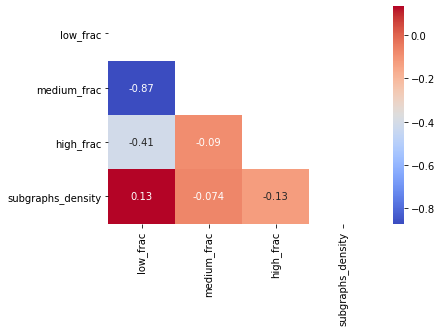

In [54]:
corr=temp[['low_frac', 'medium_frac', 'high_frac', 'subgraphs_density']].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix, cmap='coolwarm')

#sns.heatmap(temp[['low_frac', 'medium_frac', 'high_frac', 'money_displaced_nedge_frac']].corr(), cmap='coolwarm')

# Modelling

In [55]:
nodes = pd.read_csv('UofT_nodes.csv')
occupation_risk = pd.read_csv('UofT_occupation_risk.csv').set_index('code')['occupation_risk']

nodes['OCPTN_RISK'] = nodes['OCPTN_NM'].map(occupation_risk)

nodes['BIRTH_DT'] = pd.to_datetime(nodes['BIRTH_DT'])
nodes['CUST_ADD_DT'] = pd.to_datetime(nodes['CUST_ADD_DT'])

nodes['CUST_YEARS'] = 2022 - nodes['CUST_ADD_DT'].dt.year
nodes['AGE'] = 2022 - nodes['BIRTH_DT'].dt.year

nodes_aug = nodes[nodes['CUSTOMER_ID'].isin(nodes_df['CUSTOMER_ID'])]
nodes_aug = nodes_aug.merge(nodes_df, on='CUSTOMER_ID')

imputer = SimpleImputer(strategy='most_frequent')
nodes_aug = pd.DataFrame(imputer.fit_transform(nodes_aug), columns=nodes_aug.columns).sample(frac=1)

In [ ]:
nodes_aug = pd.read_csv('nodes_data_graph.csv')

In [119]:
nodes_aug.to_csv('nodes_data_graph.csv', index=False)

In [93]:
nodes_aug = nodes_aug[~np.any((nodes_aug == np.inf), axis=1)]

## basic dataset modelling

In [56]:
balanced_results = dict()

In [57]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE']#, 'degree', 'closeness_centrality',
           #'subgraph_size', 'sent', 'received', 'node_sg_degree_frac', 'diameter_len_frac', 'money_displaced_len_frac']#, 'subgraphs_avg_money_sent','subgraphs_avg_money_received']
cat_ohe_cols = []#, 'OCPTN_RISK']
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

# for col in cat_non_ohe_cols:
#     imputer = SimpleImputer(strategy='most_frequent')
#     data[col] = imputer.fit_transform(data[col].values.reshape(-1, 1))
    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [58]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [59]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.44s/it]


In [60]:
balanced_results['Baseline'] = results
results

,train,val,test
low,0.999558,0.999250,0.999269
medium,0.930664,0.915354,0.915399
high,0.788186,0.740606,0.740939
mcc,0.909985,0.889582,0.889701


## Graph theory augmented dataset Modelling

## Training model

### Degree + cc 


In [61]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'degree', 'closeness_centrality',
           ]
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [62]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [63]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.33s/it]


In [64]:
balanced_results['degree+cc'] = results
results

,train,val,test
low,0.999549,0.999266,0.999228
medium,0.937277,0.923129,0.923281
high,0.804080,0.759079,0.759620
mcc,0.917717,0.898725,0.898911


### Degree + cc + moneyinout 

In [103]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'degree', 'closeness_centrality',
          'sent', 'received',]
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [104]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [105]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.40s/it]


In [106]:
balanced_results['money-sent-received'] = results
results

,train,val,test
low,0.999578,0.999266,0.999231
medium,0.939107,0.924843,0.924255
high,0.808841,0.762801,0.761333
mcc,0.919958,0.900683,0.899951


### Degree + cc + moneyinout + node_sg_degree_frac 

In [88]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'degree', 'closeness_centrality',
          'sent', 'received', 'node_sg_degree_frac',]
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]
    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [89]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [90]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:44<00:00, 10.40s/it]


In [91]:
balanced_results['node_subgraph\ndegree_frac'] = results
results

,train,val,test
low,0.999596,0.999312,0.999260
medium,0.942173,0.927016,0.927009
high,0.817232,0.768680,0.768389
mcc,0.923769,0.903409,0.903307


### Previous + money_displaced

In [107]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'degree', 'closeness_centrality',
          'subgraph_size', 'edge_node_frac', 'sent', 'received', 'node_sg_degree_frac', 
           'money_displaced_nedge_frac',]
       #'subgraphs_density', 'edge_node_frac'] 
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]
    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [108]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [109]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.63s/it]


In [110]:
balanced_results['money_displaced'] = results
results

,train,val,test
low,0.999588,0.999266,0.999266
medium,0.942896,0.928345,0.928177
high,0.818302,0.771148,0.770731
mcc,0.924485,0.904823,0.904613


### Previous + subgraphs_density

In [111]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'degree', 'closeness_centrality',
          'subgraph_size', 'edge_node_frac', 'sent', 'received', 'node_sg_degree_frac', 
           'money_displaced_nedge_frac',
       'subgraphs_density'] 
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]
    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [112]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [113]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.75s/it]


In [114]:
balanced_results['subgraphs_density'] = results
results

,train,val,test
low,0.999592,0.999277,0.999217
medium,0.943504,0.929108,0.928704
high,0.819764,0.773403,0.771896
mcc,0.925204,0.905809,0.905184


### Score Progression

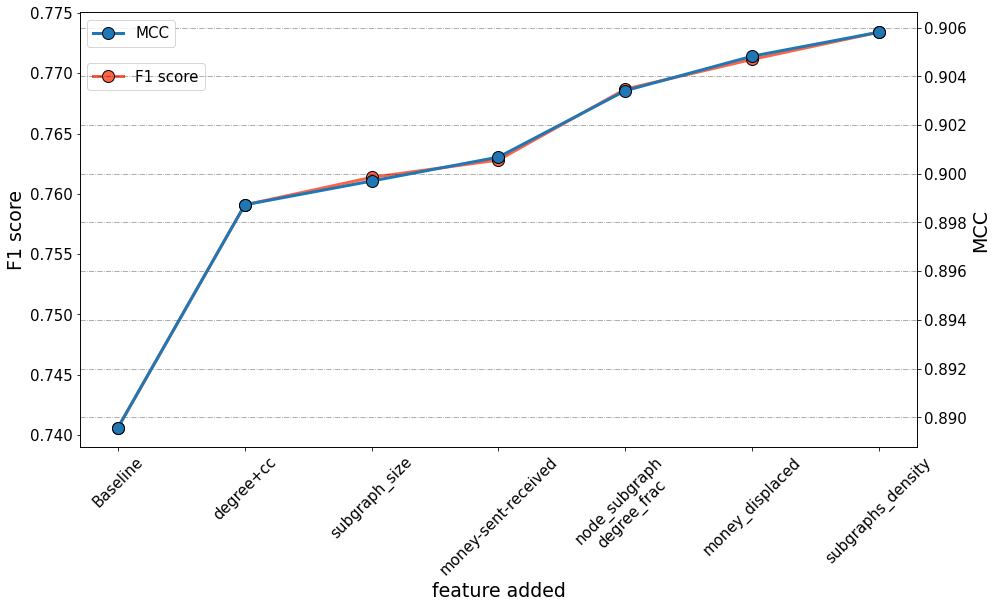

In [115]:
tags, scores = get_results_list(balanced_results, row='high', col='val')
_, scores2 = get_results_list(balanced_results, row='mcc', col='val')

plt.figure(figsize=(15, 8))

plt.plot(scores, '-o', linewidth=3, markersize=12, mec='k', color='tomato', label='F1 score')
# plt.plot(range(0, 5), temp2['medium'], '-o', linewidth=5, markersize=12, mec='k', label='Medium risk proportion')
# plt.plot(range(0, 5), temp2['high'], '-o', linewidth=5, markersize=12, mec='k', label='High risk proportion')

#plt.title('Subgraph Diameter-Order frac Vs Risk Proportions', fontsize=24, loc='Left', y=1.05)

plt.ylabel('F1 score', fontsize=19)
#plt.yticks(ticks=[0.1*i for i in range(7)], labels=[f'{i*10}%' for i in range(7)], fontsize=17)

plt.xlabel('feature added', fontsize=19)
plt.xticks(ticks=range(0, len(tags)), labels=tags, fontsize=15, rotation=45)
plt.yticks(fontsize=15)

ax = plt.gca()
ax2 = ax.twinx()


ax2.plot(scores2, '-o', linewidth=3, markersize=12, mec='k', label='MCC')
ax2.tick_params(axis='y', labelsize=15)
ax2.set_ylabel('MCC', fontsize=19)


ax.legend(fontsize=15, loc='upper left', bbox_to_anchor=(0,0.9))
ax2.legend(loc='upper left', fontsize=15)
plt.grid(alpha=0.4, linestyle='-.', color='k')

# Removing 2 node graphs from dataset

This part is concerned with basically finding out the results on 2 node graphs, we wanted to observe the performance on just the 2 nodes graph

## basic dataset modelling

In [733]:
balanced_results_2 = dict()

In [734]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE']#, 'degree', 'closeness_centrality',
           #'subgraph_size', 'sent', 'received', 'node_sg_degree_frac', 'diameter_len_frac', 'money_displaced_len_frac']#, 'subgraphs_avg_money_sent','subgraphs_avg_money_received']
cat_ohe_cols = []#, 'OCPTN_RISK']
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

# for col in cat_non_ohe_cols:
#     imputer = SimpleImputer(strategy='most_frequent')
#     data[col] = imputer.fit_transform(data[col].values.reshape(-1, 1))
    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [735]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [736]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs, remove_sg_2=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.59s/it]


In [737]:
balanced_results_2['Baseline'] = results
results

,train,val,test
low,0.999677,0.999723,0.999582
medium,0.936498,0.923995,0.923565
high,0.717479,0.673870,0.667165
mcc,0.924983,0.911033,0.910142


## Graph theory augmented dataset Modelling

## Training model

### Degree + cc 


In [738]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'degree', 'closeness_centrality',
           ]
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [739]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [740]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs, remove_sg_2=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:44<00:00, 10.46s/it]


In [741]:
balanced_results_2['degree+cc'] = results
results

,train,val,test
low,0.999691,0.999568,0.999628
medium,0.948237,0.935761,0.936382
high,0.733979,0.674290,0.672724
mcc,0.936031,0.920558,0.921349


### Degree + cc + subgraph_size


In [742]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'degree', 'closeness_centrality',
          'subgraph_size']
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [743]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [744]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs, remove_sg_2=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.19s/it]


In [745]:
balanced_results_2['subgraph_size'] = results
results

,train,val,test
low,0.999685,0.999620,0.999613
medium,0.948548,0.936048,0.935377
high,0.737289,0.668514,0.665526
mcc,0.936466,0.920724,0.919984


### Degree + cc + subgraph_size + moneyinout 

In [746]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'degree', 'closeness_centrality',
          'subgraph_size', 'sent', 'received',]
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [747]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [748]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs, remove_sg_2=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.20s/it]


In [749]:
balanced_results_2['money-sent-received'] = results
results

,train,val,test
low,0.999679,0.999654,0.999613
medium,0.947741,0.936460,0.935564
high,0.732623,0.670483,0.668315
mcc,0.935445,0.921222,0.920295


### Degree + cc + subgraph_size + moneyinout + node_sg_degree_frac 

In [750]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'degree', 'closeness_centrality',
          'subgraph_size', 'sent', 'received', 'node_sg_degree_frac',]
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]
    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [751]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [752]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs, remove_sg_2=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:59<00:00, 11.93s/it]


In [753]:
balanced_results_2['node_subgraph\ndegree_frac'] = results
results

,train,val,test
low,0.999645,0.999635,0.999597
medium,0.947590,0.935398,0.935551
high,0.732218,0.671853,0.670178
mcc,0.935259,0.920296,0.920435


### Previous + Subgraph Risk prop correlated features

In [754]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'degree', 'closeness_centrality',
          'subgraph_size', 'sent', 'received', 'node_sg_degree_frac', 
           'money_displaced_nedge_frac',
       'subgraphs_density', 'edge_node_frac'] 
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_aug[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]
    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols)

In [755]:
class_weights = {0: 0.999999999998889, 1: 1.17, 2: 1.98}

In [756]:
kwargs = {'early_stopping_rounds':50, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict, kwargs=kwargs, remove_sg_2=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:50<00:00, 11.04s/it]


In [757]:
balanced_results_2['SG_risk_prop\ncorrelated_features'] = results
results

,train,val,test
low,0.999709,0.999491,0.999582
medium,0.948634,0.935519,0.935493
high,0.735527,0.669396,0.667259
mcc,0.936519,0.919920,0.920149


### Score Progression

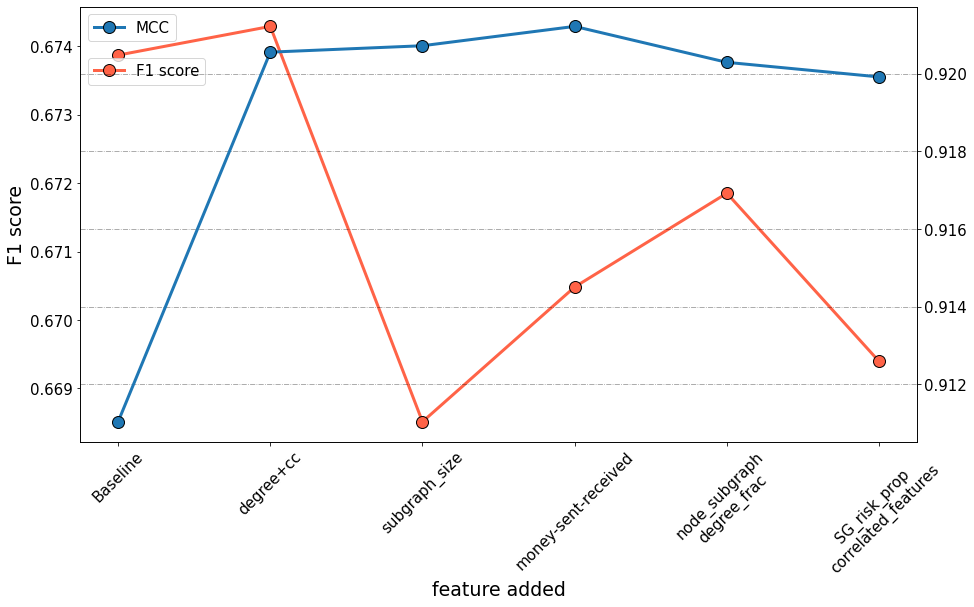

In [759]:
tags, scores = get_results_list(row='high', col='val', balanced=balanced_results_2)
_, scores2 = get_results_list(row='mcc', col='val', balanced=balanced_results_2)

plt.figure(figsize=(15, 8))

plt.plot(scores, '-o', linewidth=3, markersize=12, mec='k', color='tomato', label='F1 score')
# plt.plot(range(0, 5), temp2['medium'], '-o', linewidth=5, markersize=12, mec='k', label='Medium risk proportion')
# plt.plot(range(0, 5), temp2['high'], '-o', linewidth=5, markersize=12, mec='k', label='High risk proportion')

#plt.title('Subgraph Diameter-Order frac Vs Risk Proportions', fontsize=24, loc='Left', y=1.05)

plt.ylabel('F1 score', fontsize=19)
#plt.yticks(ticks=[0.1*i for i in range(7)], labels=[f'{i*10}%' for i in range(7)], fontsize=17)

plt.xlabel('feature added', fontsize=19)
plt.xticks(ticks=range(0, len(tags)), labels=tags, fontsize=15, rotation=45)
plt.yticks(fontsize=15)

ax = plt.gca()
ax2 = ax.twinx()


ax2.plot(scores2, '-o', linewidth=3, markersize=12, mec='k', label='MCC')
ax2.tick_params(axis='y', labelsize=15)


ax.legend(fontsize=15, loc='upper left', bbox_to_anchor=(0,0.9))
ax2.legend(loc='upper left', fontsize=15)
plt.grid(alpha=0.4, linestyle='-.', color='k')